# Big Data: SP25 - CSGY - 6513
## Contributors: Rudra Patil, Rigved Shirvalkar, Om Thakur

## Retail Clickstream Analysis and Prediction

In [ ]:
#Install Pyspark and circlify
!pip install pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path = "../input/2019-oct/2019-Oct.csv"
!unzip "/content/drive/MyDrive/Homeworks/Sem 2/Big Data/2019-Oct.csv.zip"
# !unzip "/content/drive/MyDrive/BigDataSet/archive.zip"

Archive:  /content/drive/MyDrive/Homeworks/Sem 2/Big Data/2019-Oct.csv.zip
  inflating: 2019-Oct.csv            


In [ ]:
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
from pyspark.sql.window import Window
from pyspark.sql.functions import element_at, split, col
import pandas as pd
import os
import plotly.express as px

In [ ]:
# Initialize Spark configuration
configuration = pyspark.SparkConf()
configuration.set('spark.sql.repl.eagerEval.enabled', True)

# Set up Spark Context
spark_context = pyspark.SparkContext(conf=configuration)

# Create or retrieve the existing Spark SQL Context
sql_context = pyspark.SQLContext.getOrCreate(spark_context)


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
#Creating a subset of
# def read_with_pandas(input_filepath):
#   raw_data = pd.read_csv(input_filepath, nrows = 500000)
#   output_filepath = "small_oct_2019.csv"
#   raw_data.to_csv(output_filepath)
#   return output_filepath

# input_filepath = "/content/2019-Oct.csv"
# input_filepath = read_with_pandas(input_filepath)

In [ ]:
# change here for testing
# for v local machine
path_file_2019 = "/content/2019-Oct.csv"
output_show = True # it makes .show() on/off
small_data_testing = False # make it false when testing on whole dataset
if small_data_testing:
  raw_data = pd.read_csv(path_file_2019, nrows = 5000)
  raw_data.head(2)
  raw_data.to_csv("small_oct_2019.csv")
  path_file_2019 = "/content/small_oct_2019.csv"

print("the file chosen is ", path_file_2019)
print("small data testing is ", small_data_testing)

the file chosen is  /content/2019-Oct.csv
small data testing is  False


In [ ]:
# For final we will take the full dataset
#path_file_2019 = "/content/drive/MyDrive/Awesom_Big_Data_Project/small_oct_2019.csv"
# Load the original dataset from CSV file
initial_df = sql_context.read \
    .format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(path_file_2019)

In [ ]:
# Just keeping original_df in case we do some operation on df and loose track of original df
# add hyperloglog. Thats faster(Daniel)
# https://mungingdata.com/apache-spark/hyperloglog-count-distinct/
preprocessed_df = initial_df

# **Dataset Overview**

In [ ]:
preprocessed_df.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



1) ***event_time*** : denotes the date and time of the user session.

2) ***event_type***: There are 3 events in this dataset (viewing, adding to cart, and purchase).

3) ***product_id***: indicates the specific product id.

4) ***category_id***: indicates the specific category id.

5) ***user_id***: pertains to the specific user.

6) ***user session***: a single user can have multiple sessions indicating various events like view, purchase, add to cart.

7) ***brand***: indicates the brand associated with the product and category.

8) ***cateogry***: indicates a nested string having a structure liek electronics.smartphone.andorid which helps us in specifying the range of purchased item.



# Data Summary and Pre-processing

In [ ]:
# Remove rows where 'event_type' field is missing
cleaned_df = preprocessed_df.na.drop(subset=["event_type"])

# Data Imputation

## Extracting Catgeory and Product

In [ ]:
# Fill missing values in 'category_code' and 'brand' columns with the placeholder "empty"
filled_df = cleaned_df.fillna("empty", subset=["category_code", "brand"])

In [ ]:
if output_show:
  preprocessed_df.show(5)

+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 00:00:00|      view|  44600062|2103807459595387724|                NULL|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 00:00:00|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|   33.2|554748717|9333dfbd-b87a-470...|
|2019-10-01 00:00:01|      view|  17200506|2053013559792632471|furniture.living_...|    NULL|  543.1|519107250|566511c2-e2e3-422...|
|2019-10-01 00:00:01|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 00:00:04|      view|   1004237|2053013555631882655|electr

In [ ]:
# Define UDFs to extract category and product names from 'category_code' or fallback to 'brand'
from pyspark.sql.functions import udf

@udf
def get_category_name(category_code, brand_name):
    parts = str(category_code).split('.')
    if parts[0] == "empty":
        return brand_name if brand_name != "empty" else "unknown"
    return parts[0]

@udf
def get_product_name(category_code, brand_name):
    parts = str(category_code).split('.')
    if parts[-1] == "empty":
        return brand_name if brand_name != "empty" else "unknown"
    return parts[-1]

In [ ]:
# Apply the UDFs to extract category and product names
df_with_extracted_fields = filled_df.select(
    "*",
    get_category_name("category_code", "brand").alias("category"),
    get_product_name("category_code", "brand").alias("product")
)

# Drop the original 'category_code' column
df_with_extracted_fields = df_with_extracted_fields.drop("category_code")

# Display the first 5 rows if output is enabled
if output_show:
    df_with_extracted_fields.show(5)


+-------------------+----------+----------+-------------------+--------+-------+---------+--------------------+-----------+------------+
|         event_time|event_type|product_id|        category_id|   brand|  price|  user_id|        user_session|   category|     product|
+-------------------+----------+----------+-------------------+--------+-------+---------+--------------------+-----------+------------+
|2019-10-01 00:00:00|      view|  44600062|2103807459595387724|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|   shiseido|    shiseido|
|2019-10-01 00:00:00|      view|   3900821|2053013552326770905|    aqua|   33.2|554748717|9333dfbd-b87a-470...| appliances|water_heater|
|2019-10-01 00:00:01|      view|  17200506|2053013559792632471|   empty|  543.1|519107250|566511c2-e2e3-422...|  furniture|        sofa|
|2019-10-01 00:00:01|      view|   1307067|2053013558920217191|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|  computers|    notebook|
|2019-10-01 00:00:04|      view|   100423

## Extracting Time features like Day, Time, Hour from Timestamp

In [ ]:
# Extract 'Day' and 'Hour' from the 'event_time' column
df_time_transformed = df_with_extracted_fields \
    .withColumn('date_section', split(col('event_time'), ' ').getItem(0)) \
    .withColumn('time_section', split(col('event_time'), ' ').getItem(1)) \
    .withColumn('Day', split(col('date_section'), '-').getItem(2)) \
    .withColumn('Hour', split(col('time_section'), ':').getItem(0)) \
    .drop('date_section')

# Display top 5 records if output flag is enabled
if output_show:
    df_time_transformed.show(5)


+-------------------+----------+----------+-------------------+--------+-------+---------+--------------------+-----------+------------+------------+---+----+
|         event_time|event_type|product_id|        category_id|   brand|  price|  user_id|        user_session|   category|     product|time_section|Day|Hour|
+-------------------+----------+----------+-------------------+--------+-------+---------+--------------------+-----------+------------+------------+---+----+
|2019-10-01 00:00:00|      view|  44600062|2103807459595387724|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|   shiseido|    shiseido|    00:00:00| 01|  00|
|2019-10-01 00:00:00|      view|   3900821|2053013552326770905|    aqua|   33.2|554748717|9333dfbd-b87a-470...| appliances|water_heater|    00:00:00| 01|  00|
|2019-10-01 00:00:01|      view|  17200506|2053013559792632471|   empty|  543.1|519107250|566511c2-e2e3-422...|  furniture|        sofa|    00:00:01| 01|  00|
|2019-10-01 00:00:01|      view|   1307067|205

In [ ]:
df = df_time_transformed

# Unique visitors in October

In [ ]:
visitor_count = df.select(countDistinct("user_id")).collect()[0][0]
print(visitor_count)

3022290


Analysis: The e-commerce site has a footfall of X unique visitors in the month of October

Future scope: If latitude/longitude is captured, we can also obtain demographic insights about potential customers.


# Journey of a user in one session


In [ ]:
# Retrieve all events for a specific user session and sort them by event time
session_events_df = df.filter(col('user_session') == 'b37abd25-7672-4dd7-a098-40e50e314388') \
                      .orderBy('event_time') \
                      .toPandas()


# Analysis of User Behaviour on the e-commerce site ( 2 Options )


In [ ]:
# Analyze user behavior with a different visualization

# Create separate DataFrames for each event type
view_df = df.filter(df['event_type'] == 'view')
cart_df = df.filter(df['event_type'] == 'cart')
purchase_df = df.filter(df['event_type'] == 'purchase')

# Prepare data for plotting
event_summary = {
    'Event': ['View', 'Cart', 'Purchase'],
    'Count': [view_df.count(), cart_df.count(), purchase_df.count()]
}

# Convert to Pandas DataFrame
event_summary_df = pd.DataFrame(event_summary)

# Create a bar chart using Plotly
fig = px.bar(
    event_summary_df,
    x='Event',
    y='Count',
    text='Count',
    title='User Behavior Distribution on E-commerce Site',
    color='Event',
    template='plotly_white'
)

# Customize bar chart appearance
fig.update_traces(textposition='outside')
fig.update_layout(yaxis_title="Number of Events", xaxis_title="Event Type")
fig.show()


# Part 1: Determine best performing categories based on purchases



## Top 10 Categories Browsed and Purchased (2 options)

### Top 10 Categories browsed

In [ ]:
# Filter records for browsing (view or cart events) and purchasing separately
browsed_items_df = df.filter((col('event_type') == 'view') | (col('event_type') == 'cart'))
purchased_items_df = df.filter(col('event_type') == 'purchase')

# Exclude entries with unknown category or product in browsing events
browsed_items_df = browsed_items_df.filter((col('category') != 'unknown') & (col('product') != 'unknown'))

# Exclude entries with unknown category or product in purchasing events
purchased_items_df = purchased_items_df.filter((col('category') != 'unknown') & (col('product') != 'unknown'))

In [ ]:
# Find the top 10 most browsed categories
top_browsed_categories_df = browsed_items_df.groupBy('category') \
    .count() \
    .orderBy(desc('count')) \
    .limit(10) \
    .withColumnRenamed('count', 'browsed_category_count')

In [ ]:
# Display the top 5 browsed categories if output display is enabled
if output_show:
    top_browsed_categories_df.show(5)


+-----------+----------------------+
|   category|browsed_category_count|
+-----------+----------------------+
|electronics|              15712595|
| appliances|               4892298|
|  computers|               2296362|
|    apparel|               1534922|
|  furniture|               1238859|
+-----------+----------------------+
only showing top 5 rows



In [ ]:
# Extract category and browse count data
categories = [row.category for row in top_browsed_categories_df.select('category').collect()]
browse_counts = [row.browsed_category_count for row in top_browsed_categories_df.select('browsed_category_count').collect()]

# Create a new DataFrame for plotting
plot_data = {'Category': categories, 'Browse_Count': browse_counts}
plot_df = pd.DataFrame(plot_data)

# Create a horizontal bar chart using Plotly
fig = px.bar(
    plot_df,
    y='Category',
    x='Browse_Count',
    orientation='h',
    color='Category',
    color_discrete_sequence=px.colors.qualitative.G10,  # Different color palette
    title='Most Popular Categories Browsed by Users'
)

# Improve readability
fig.update_layout(
    xaxis_title='Number of Browses',
    yaxis_title='Category',
    template='simple_white',
    showlegend=False
)

# Add data labels outside the bars
fig.update_traces(texttemplate='%{x:,}', textposition='outside')
fig.show()


### Top 10 Categories Purchased (2 options)

In [ ]:
# Identify the top 10 categories based on purchase counts
top_purchased_categories_df = purchased_items_df.groupBy('category') \
    .count() \
    .orderBy(desc('count')) \
    .limit(10) \
    .withColumnRenamed('count', 'purchased_category_count')

In [ ]:
# Show the top purchased categories if output display is enabled
if output_show:
    top_purchased_categories_df.show()

+------------+------------------------+
|    category|purchased_category_count|
+------------+------------------------+
| electronics|                  423028|
|  appliances|                   74996|
|   computers|                   27855|
|     lucente|                   11578|
|        auto|                   10620|
|    cordiant|                   10551|
|      xiaomi|                   10021|
|   furniture|                    8301|
|     apparel|                    8002|
|construction|                    7801|
+------------+------------------------+



In [ ]:
# Extract category and purchase count data
purchase_categories = [row.category for row in top_purchased_categories_df.select('category').collect()]
purchase_counts = [row.purchased_category_count for row in top_purchased_categories_df.select('purchased_category_count').collect()]

# Create a new DataFrame for plotting
purchase_data = {
    'Category': purchase_categories,
    'Purchase_Count': purchase_counts
}
purchase_df = pd.DataFrame(purchase_data)

# Create a horizontal bar chart using Plotly
fig = px.bar(
    purchase_df,
    y='Category',
    x='Purchase_Count',
    orientation='h',
    color='Category',
    color_discrete_sequence=px.colors.qualitative.Pastel1,  # Using fresh pastel colors
    title='Top 10 Categories Purchased by Users'
)

# Customize the appearance
fig.update_layout(
    xaxis_title='Number of Purchases',
    yaxis_title='Category',
    template='plotly_white',
    showlegend=False
)

# Add purchase count labels outside bars
fig.update_traces(texttemplate='%{x:,}', textposition='outside')
fig.show()


Analysis: Top 10 for viewed and purchased differ

## Carted vs Purchased - Top Performing Products

In [ ]:
# Analyze items that were added to cart
carted_items_df = df.filter(col('event_type') == 'cart')

# Group by category and product to find cart counts
cart_count_df = carted_items_df.groupBy('category', 'product') \
    .count() \
    .orderBy(desc('count')) \
    .withColumnRenamed('count', 'cart_count')

# Display the top 5 items added to cart if output display is enabled
if output_show:
    cart_count_df.show(5)


+-----------+----------+----------+
|   category|   product|cart_count|
+-----------+----------+----------+
|electronics|smartphone|    549765|
|electronics| headphone|     51143|
|electronics|        tv|     36224|
|     xiaomi|    xiaomi|     22246|
| appliances|    washer|     21977|
+-----------+----------+----------+
only showing top 5 rows



In [ ]:
# Group purchased items by category and product to compute purchase counts
purchased_products_df = purchased_items_df.groupBy('category', 'product') \
    .count() \
    .orderBy(desc('count')) \
    .withColumnRenamed('count', 'purchase_count')

# Display the top purchased products if output display is enabled
if output_show:
    purchased_products_df.show()

+-----------+-------------+--------------+
|   category|      product|purchase_count|
+-----------+-------------+--------------+
|electronics|   smartphone|        338018|
|electronics|    headphone|         30503|
|electronics|           tv|         21565|
|electronics|       clocks|         17906|
| appliances|       washer|         16148|
|  computers|     notebook|         15590|
| appliances|       vacuum|         12378|
|    lucente|      lucente|         11578|
| appliances|refrigerators|         11218|
|   cordiant|     cordiant|         10551|
|     xiaomi|       xiaomi|         10021|
|   triangle|     triangle|          5835|
|electronics|       tablet|          5603|
|     nokian|       nokian|          4907|
|       auto|       player|          4647|
|       sony|         sony|          4496|
|    apparel|        shoes|          4255|
|electronics|    telephone|          3738|
| appliances|    microwave|          3709|
| appliances|         iron|          3653|
+----------

In [ ]:
# Join carted and purchased products on category and product to analyze conversion
product_conversion_df = cart_count_df.join(
    purchased_products_df,
    on=["category", "product"],
    how="left"
).orderBy(desc('purchase_count')).limit(20)

# Display the top 20 products based on purchase count if output display is enabled
if output_show:
    product_conversion_df.show()


+-----------+-------------+----------+--------------+
|   category|      product|cart_count|purchase_count|
+-----------+-------------+----------+--------------+
|electronics|   smartphone|    549765|        338018|
|electronics|    headphone|     51143|         30503|
|electronics|           tv|     36224|         21565|
|electronics|       clocks|     20344|         17906|
| appliances|       washer|     21977|         16148|
|  computers|     notebook|     15627|         15590|
| appliances|       vacuum|     17263|         12378|
| appliances|refrigerators|     13126|         11218|
|   cordiant|     cordiant|      5730|         10551|
|     xiaomi|       xiaomi|     22246|         10021|
|   triangle|     triangle|       557|          5835|
|electronics|       tablet|      9140|          5603|
|     nokian|       nokian|      4906|          4907|
|       auto|       player|      1289|          4647|
|       sony|         sony|      6997|          4496|
|electronics|    telephone| 

In [ ]:
#Getting values for x-axis and y-axis
# Extract product names, cart counts, and purchase counts for plotting
products = [row.product for row in purchased_products_df.select('product').collect()]
cart_counts = [row.cart_count for row in cart_count_df.select('cart_count').collect()]
purchase_counts = [row.purchase_count for row in purchased_products_df.select('purchase_count').collect()]

In [ ]:
import plotly.graph_objects as go

# Create the grouped horizontal bar chart
fig = go.Figure()

# Add Cart Count bars
fig.add_trace(go.Bar(
    y=product_conversion_df.select('product').rdd.flatMap(lambda x: x).collect(),
    x=product_conversion_df.select('cart_count').rdd.flatMap(lambda x: x).collect(),
    name='Carted Count',
    orientation='h',
    marker_color='lightblue'
))

# Add Purchase Count bars
fig.add_trace(go.Bar(
    y=product_conversion_df.select('product').rdd.flatMap(lambda x: x).collect(),
    x=product_conversion_df.select('purchase_count').rdd.flatMap(lambda x: x).collect(),
    name='Purchased Count',
    orientation='h',
    marker_color='salmon'
))

# Update the layout
fig.update_layout(
    barmode='group',
    title='Carted vs Purchased Count — Top Performing Products',
    xaxis_title='Number of Actions',
    yaxis_title='Products',
    template='simple_white',
    height=700,
    width=900
)

# Show the figure
fig.show()


### Top 5 Products Purchased in each Category

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank

# Create a window specification to partition by category and order by purchase count
category_window = Window.partitionBy(purchased_products_df['category']).orderBy(purchased_products_df['purchase_count'].desc())

# Apply rank within each category and filter top 5 products
ranked_products_df = purchased_products_df.select(
    "*",
    rank().over(category_window).alias("rank")
).filter(col('rank') <= 5)

# Display the top ranked products if output display is enabled
if output_show:
    ranked_products_df.orderBy(desc('purchase_count')).show(20)


+-----------+-------------+--------------+----+
|   category|      product|purchase_count|rank|
+-----------+-------------+--------------+----+
|electronics|   smartphone|        338018|   1|
|electronics|    headphone|         30503|   2|
|electronics|           tv|         21565|   3|
|electronics|       clocks|         17906|   4|
| appliances|       washer|         16148|   1|
|  computers|     notebook|         15590|   1|
| appliances|       vacuum|         12378|   2|
|    lucente|      lucente|         11578|   1|
| appliances|refrigerators|         11218|   3|
|   cordiant|     cordiant|         10551|   1|
|     xiaomi|       xiaomi|         10021|   1|
|   triangle|     triangle|          5835|   1|
|electronics|       tablet|          5603|   5|
|     nokian|       nokian|          4907|   1|
|       auto|       player|          4647|   1|
|       sony|         sony|          4496|   1|
|    apparel|        shoes|          4255|   1|
| appliances|    microwave|          370

Analysis: We can see that within electronics, smartphones are the most purchased products

### Top 5 Brands Browsed within each category

In [ ]:
# Group browsed items by category and brand to compute browse counts
browsed_brand_count_df = browsed_items_df.groupBy('category', 'brand') \
    .count() \
    .orderBy(desc('count'))

# Display the top 5 browsed brand-category combinations if output display is enabled
if output_show:
    browsed_brand_count_df.show(5)


+-----------+-------+-------+
|   category|  brand|  count|
+-----------+-------+-------+
|electronics|samsung|4356048|
|electronics|  apple|3847629|
|electronics| xiaomi|2483135|
|electronics| huawei|1066546|
|  furniture|  empty| 703390|
+-----------+-------+-------+
only showing top 5 rows



In [ ]:
# Create a window specification to rank brands within each category based on browse count
brand_window = Window.partitionBy(browsed_brand_count_df['category']).orderBy(browsed_brand_count_df['count'].desc())

# Rank brands within each category and filter the top 5
ranked_brands_df = browsed_brand_count_df.select(
    "*",
    rank().over(brand_window).alias("rank")
).filter(col('rank') <= 5)

# Display the top ranked brands per category if output display is enabled
if output_show:
    ranked_brands_df.orderBy(desc('count')).show(5)


+-----------+-------+-------+----+
|   category|  brand|  count|rank|
+-----------+-------+-------+----+
|electronics|samsung|4356048|   1|
|electronics|  apple|3847629|   2|
|electronics| xiaomi|2483135|   3|
|electronics| huawei|1066546|   4|
|  furniture|  empty| 703390|   1|
+-----------+-------+-------+----+
only showing top 5 rows



Analysis: We can see that within electronics, samsung is most browsed brand

### Top 5 brands within each category Purchased

In [ ]:
# Group purchased items by category and brand to compute purchase counts
purchased_brand_count_df = purchased_items_df.groupBy('category', 'brand') \
    .count() \
    .orderBy(desc('count'))

# Display the top 5 purchased brand-category combinations if output display is enabled
if output_show:
    purchased_brand_count_df.show(5)


+-----------+-------+------+
|   category|  brand| count|
+-----------+-------+------+
|electronics|samsung|159621|
|electronics|  apple|141394|
|electronics| xiaomi| 44767|
|electronics| huawei| 23220|
|    lucente|lucente| 11578|
+-----------+-------+------+
only showing top 5 rows



In [ ]:
# Create a window specification to rank brands within each category based on purchase count
purchased_brand_window = Window.partitionBy(purchased_brand_count_df['category']).orderBy(purchased_brand_count_df['count'].desc())

# Rank brands within each category and filter the top 5
ranked_purchased_brands_df = purchased_brand_count_df.select(
    "*",
    rank().over(purchased_brand_window).alias("rank")
).filter(col('rank') <= 5)

# Display the top ranked purchased brands per category if output display is enabled
if output_show:
    ranked_purchased_brands_df.orderBy(desc('count')).show(5)

+-----------+-------+------+----+
|   category|  brand| count|rank|
+-----------+-------+------+----+
|electronics|samsung|159621|   1|
|electronics|  apple|141394|   2|
|electronics| xiaomi| 44767|   3|
|electronics| huawei| 23220|   4|
|    lucente|lucente| 11578|   1|
+-----------+-------+------+----+
only showing top 5 rows



In [ ]:
import plotly.express as px

# Prepare the data: extract category, brand, and count for plotting
purchased_brand_data = purchased_brand_count_df.select('category', 'brand', 'count').toPandas()

# Step 1: Get top 10 categories by total purchases
top_10_categories = (
    purchased_brand_data
    .groupby('category')['count']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Step 2: Filter for top 10 categories
filtered_data = purchased_brand_data[purchased_brand_data['category'].isin(top_10_categories)]

# Step 3: Get top 5 brands per category
top_brands = (
    filtered_data
    .sort_values(['category', 'count'], ascending=[True, False])
    .groupby('category')
    .head(5)
)

# Step 4: Build the Treemap
fig = px.treemap(
    top_brands,
    path=['category', 'brand'],  # first level = category, second level = brand
    values='count',
    color='category',  # Different colors for each category
    title='Top Purchased Brands across Categories',
    color_discrete_sequence=px.colors.qualitative.Pastel  # Soft, professional color palette
)

# Step 5: Show the Treemap
fig.show()




In [ ]:
# browsed_brand_data = browsed_brand_count_df.select('category', 'brand', 'count').toPandas()

# Step 1: Convert to pandas DataFrame
browsed_brand_data = browsed_brand_count_df.select('category', 'brand', 'count').toPandas()

# Step 2: Get top 10 categories by total count
top_10_categories = (
    browsed_brand_data
    .groupby('category')['count']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Step 3: Filter data to only top 10 categories
filtered_data = browsed_brand_data[browsed_brand_data['category'].isin(top_10_categories)]

# Step 4: Get top 5 brands within each of the top 10 categories
top_brands = (
    filtered_data
    .sort_values(['category', 'count'], ascending=[True, False])
    .groupby('category')
    .head(5)
)

# Step 5: Plot treemap
fig = px.treemap(
    top_brands,
    path=['category', 'brand'],
    values='count',
    color='category',
    title='Top Browsed Brands across Categories',
    color_discrete_sequence=px.colors.qualitative.G10
)
fig.show()

Analysis: TBD

# Part 2: Evaluate Add to Cart and Cart Abandonment Rate



## Cart Abandonment Rate

In [ ]:
# Filter data for cart events
only_cart_df = df.filter(col('event_type') == 'cart')

# Filter data for purchase events
only_purchase_df = df.filter(col('event_type') == 'purchase')


### CAR by Category

In [ ]:
#Distinct category in cart
df_only_cart_cat_dis = only_cart_df.groupBy("category").count()
df_only_cart_cat_dis = df_only_cart_cat_dis.withColumnRenamed("count", "cart_count")

#Distinct category in purchase
df_only_purchase_cat_dis = only_purchase_df.groupBy("category").count()
df_only_purchase_cat_dis = df_only_purchase_cat_dis.withColumnRenamed("count", "purchase_count")

#Performing a left join
columns_ = df.columns
cart_purchase = df_only_cart_cat_dis.alias("cart_cat").join(df_only_purchase_cat_dis.alias("purchase_cat"),
                                                            df_only_cart_cat_dis["category"]==df_only_purchase_cat_dis["category"]).select("cart_cat.category", "cart_cat.cart_count", "purchase_cat.purchase_count")
if output_show:
  cart_purchase.show(5)

+---------+----------+--------------+
| category|cart_count|purchase_count|
+---------+----------+--------------+
| yokohama|      1758|          2735|
|  versace|       270|           465|
|  philips|      3337|          2417|
|energizer|         2|            14|
|microsoft|       298|           202|
+---------+----------+--------------+
only showing top 5 rows



In [ ]:
# Calculate distinct cart counts per category
cart_category_count_df = only_cart_df.groupBy('category') \
    .count() \
    .withColumnRenamed('count', 'cart_count')

# Calculate distinct purchase counts per category
purchase_category_count_df = only_purchase_df.groupBy('category') \
    .count() \
    .withColumnRenamed('count', 'purchase_count')

# Perform a left join between cart and purchase counts on category
cart_purchase_df = cart_category_count_df.alias('cart_cat').join(
    purchase_category_count_df.alias('purchase_cat'),
    cart_category_count_df['category'] == purchase_category_count_df['category'],
    how='left'
).select(
    col('cart_cat.category'),
    col('cart_cat.cart_count'),
    col('purchase_cat.purchase_count')
)

# Display the merged cart-purchase counts if output display is enabled
if output_show:
    cart_purchase_df.show(5)


+--------+----------+--------------+
|category|cart_count|purchase_count|
+--------+----------+--------------+
|yokohama|      1758|          2735|
| versace|       270|           465|
|cordiant|      5730|         10551|
|  jaguar|       238|           135|
| matador|      3200|          1711|
+--------+----------+--------------+
only showing top 5 rows



In [ ]:
# # Define a UDF to calculate Cart Abandonment Rate
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

@udf(returnType=FloatType())
def calculate_cart_abandonment_rate(cart_count, purchase_count):
    if cart_count == 0:
        return None  # Avoid division by zero
    rate = (1 - (purchase_count / cart_count)) * 100
    return rate


In [ ]:
@udf(returnType=FloatType())
def cart_miss_rate_udf(cart_count, purchase_count):
  rate = (1 - purchase_count/cart_count)*100
  #rate_string = "{:.2f}".format(rate)
  return rate

In [ ]:
df_cart_miss_rate = cart_purchase.select("*", cart_miss_rate_udf("cart_count", "purchase_count"))
df_cart_miss_rate = df_cart_miss_rate.withColumnRenamed("cart_miss_rate_udf(cart_count, purchase_count)", "cart_miss_rate")
df_cart_miss_rate = df_cart_miss_rate.filter("cart_miss_rate>0")
df_cart_miss_rate = df_cart_miss_rate.filter("cart_count>5000")
df_cart_miss_rate = df_cart_miss_rate.orderBy(desc("cart_miss_rate")).limit(10)
if output_show:
  df_cart_miss_rate.show(5)

+------------+----------+--------------+--------------+
|    category|cart_count|purchase_count|cart_miss_rate|
+------------+----------+--------------+--------------+
|      xiaomi|     22246|         10021|       54.9537|
| electronics|    674205|        423028|     37.255287|
|        sony|      6997|          4496|      35.74389|
|construction|     10343|          7801|      24.57701|
|  appliances|     92362|         74996|     18.802105|
+------------+----------+--------------+--------------+



In [ ]:
import plotly.express as px

# Prepare the data
category_list = [row.category for row in df_cart_miss_rate.select('category').collect()]
cart_miss_rate_values = [row.cart_miss_rate for row in df_cart_miss_rate.select('cart_miss_rate').collect()]

# Create a DataFrame for plotting
cart_miss_rate_df = pd.DataFrame({
    'Category': category_list,
    'Cart_Miss_Rate': cart_miss_rate_values
})

# Build a compact Donut Chart
fig = px.pie(
    cart_miss_rate_df,
    names='Category',
    values='Cart_Miss_Rate',
    hole=0.5,
    color_discrete_sequence=px.colors.qualitative.G10,
    title='Cart Abandonment Rate by Category'
)

# Tighter layout: make it less wide
fig.update_layout(
    showlegend=True,
    template='simple_white',
    width=600,   # Smaller width
    height=500,  # Adjusted height
    margin=dict(l=50, r=50, t=80, b=50)  # Reduce left, right, top, bottom margins
)

# Inside text for better compactness
fig.update_traces(
    textposition='inside',
    textinfo='percent+label'
)

# Show the plot
fig.show()


Analysis: We can see that X category had the most cart abandonment rate with X%

### CAR by Brands

In [ ]:
# Calculate distinct cart counts per brand within 'electronics' category
cart_brand_count_df = only_cart_df.filter(col('category') == 'electronics') \
    .groupBy('brand') \
    .count() \
    .withColumnRenamed('count', 'cart_count')

# Calculate distinct purchase counts per brand within 'electronics' category
purchase_brand_count_df = only_purchase_df.filter(col('category') == 'electronics') \
    .groupBy('brand') \
    .count() \
    .withColumnRenamed('count', 'purchase_count')

# Perform a left join between cart and purchase counts on brand
cart_purchase_brand_df = cart_brand_count_df.alias('cart_cat').join(
    purchase_brand_count_df.alias('purchase_cat'),
    cart_brand_count_df['brand'] == purchase_brand_count_df['brand'],
    how='left'
).select(
    col('cart_cat.brand'),
    col('cart_cat.cart_count'),
    col('purchase_cat.purchase_count')
)

# Display the cart-purchase counts for brands if output display is enabled
if output_show:
    cart_purchase_brand_df.show(5)



+---------+----------+--------------+
|    brand|cart_count|purchase_count|
+---------+----------+--------------+
|  philips|       835|           426|
|    epson|        89|            33|
|    texet|       592|           554|
|panasonic|      1006|           485|
|    apple|    207504|        141394|
+---------+----------+--------------+
only showing top 5 rows



In [ ]:
# Apply the UDF to calculate cart abandonment rate at brand level
df_cart_miss_rate_brand = cart_purchase_brand_df.select(
    "*",
    calculate_cart_abandonment_rate('cart_count', 'purchase_count').alias('cart_miss_rate_brand')
)

# Filter brands where cart miss rate is positive and cart count is significant
df_cart_miss_rate_brand = df_cart_miss_rate_brand.filter(col('cart_miss_rate_brand') > 0)
df_cart_miss_rate_brand = df_cart_miss_rate_brand.filter(col('cart_count') > 1)

# Select the top 10 brands with the highest cart abandonment rate
df_cart_miss_rate_brand = df_cart_miss_rate_brand.orderBy(desc('cart_miss_rate_brand')).limit(10)

# Convert to Pandas DataFrame for easier analysis or plotting
df_cart_miss_rate_brand_pd = df_cart_miss_rate_brand.toPandas()

# (Optional) Display the resulting DataFrame
df_cart_miss_rate_brand_pd


,brand,cart_count,purchase_count,cart_miss_rate_brand
0,bluedio,8,1,87.500000
1,cnd,19,4,78.947365
2,global,4,1,75.000000
3,blaupunkt,257,72,71.984436
4,viewsonic,29,9,68.965515
5,kurzweil,9,3,66.666664
6,xgimi,20,7,65.000000
7,epson,89,33,62.921349
8,koss,15,6,60.000000
9,troyka,48,21,56.250000


In [ ]:
import plotly.express as px

# Prepare the data
brand_list = [row.brand for row in df_cart_miss_rate_brand.select('brand').collect()]
cart_miss_rate_values = [row.cart_miss_rate_brand for row in df_cart_miss_rate_brand.select('cart_miss_rate_brand').collect()]

# Create a DataFrame for plotting
brand_miss_rate_df = pd.DataFrame({
    'Brand': brand_list,
    'Cart_Miss_Rate': cart_miss_rate_values
})

# Build a Donut Chart
fig = px.pie(
    brand_miss_rate_df,
    names='Brand',
    values='Cart_Miss_Rate',
    hole=0.5,  # Creates donut effect
    color_discrete_sequence=px.colors.qualitative.Pastel1,  # Fresh soft colors
    title='Cart Abandonment Rate by Brand'
)

# Customize layout for compactness
fig.update_layout(
    showlegend=True,
    template='simple_white',
    width=600,   # Compact width
    height=500,  # Compact height
    margin=dict(l=40, r=40, t=60, b=40)  # Tight margins
)

# Customize text display inside the donut
fig.update_traces(
    textposition='inside',
    textinfo='percent+label'
)

# Show the figure
fig.show()


Analysis: Show brands with highest abandonment rate. Business users need to talk to brand people to work on their campaign.

# Part 3: Effect of day-time on purchase trends

## Purchase trends across the month

In [ ]:
df_view = df[df['event_type'] == "view"]
df_purchase = df[df['event_type'] == "purchase"]
df_cart = df[df['event_type'] == "cart"]

In [ ]:
df_purchase_date_count = df_purchase.groupby("Day").count()

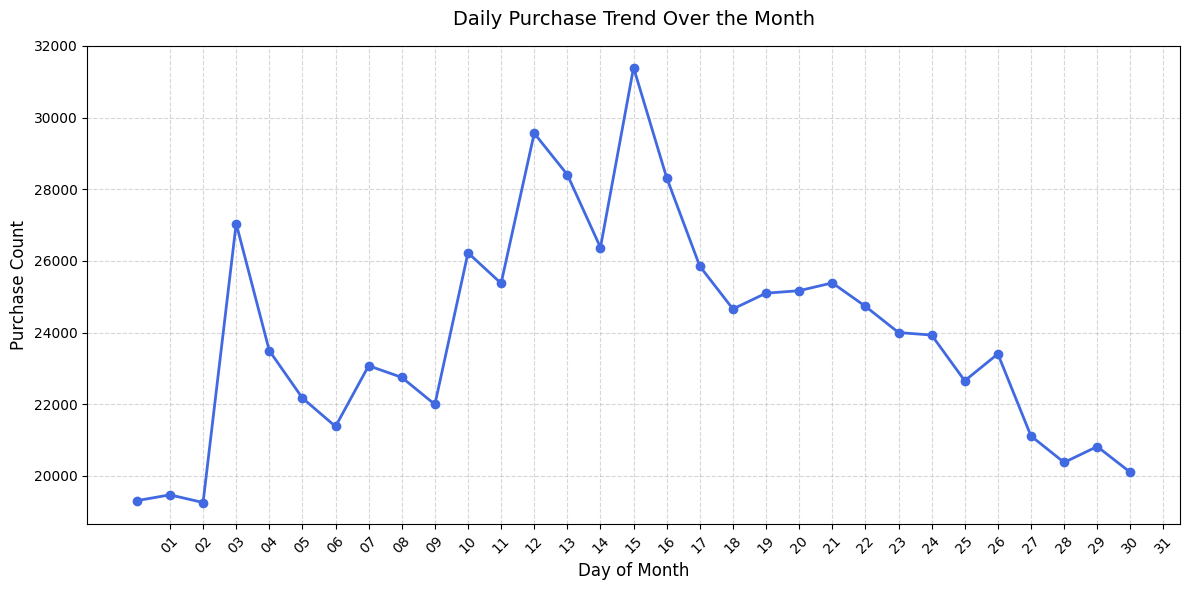

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the data
purchase_counts = [row[0] for row in df_purchase_date_count.select('count').collect()]
purchase_days = [row['Day'] for row in df_purchase_date_count.select('Day').collect()]

# Create a DataFrame for better control
purchase_trend_df = pd.DataFrame({
    'Day': purchase_days,
    'Purchase_Count': purchase_counts
})

# Set up a compact and cleaner figure
fig, ax = plt.subplots(figsize=(12, 6))  # Smaller, cleaner plot

# Plot a line + marker plot instead of plain bars
ax.plot(
    purchase_trend_df['Day'],
    purchase_trend_df['Purchase_Count'],
    marker='o', linestyle='-', color='royalblue', linewidth=2, markersize=6
)

# Add labels and title
ax.set_xlabel('Day of Month', fontsize=12)
ax.set_ylabel('Purchase Count', fontsize=12)
ax.set_title('Daily Purchase Trend Over the Month', fontsize=14, pad=15)

# Set x-axis ticks properly
ax.set_xticks(range(1, 32))
ax.set_xticklabels([f'{i:02d}' for i in range(1, 32)], rotation=45)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.5)

# Tight layout to minimize whitespace
plt.tight_layout()

# Show the plot
plt.show()


Analysis: User's buying interest is gradually increasing in the middle of the month until day 16, therefore, to increase the sales we can offer mid-month sale/discount from day 11 until 16

## E-Commerce Prime Time

In [ ]:
# Calculate hourly view counts
view_hourly_count_df = df_view.groupBy('Hour') \
    .count() \
    .withColumnRenamed('count', 'view_count')

# Calculate hourly cart counts
cart_hourly_count_df = df_cart.groupBy('Hour') \
    .count() \
    .withColumnRenamed('count', 'cart_count')

# Calculate hourly purchase counts
purchase_hourly_count_df = df_purchase.groupBy('Hour') \
    .count() \
    .withColumnRenamed('count', 'purchase_count')


In [ ]:
# Combine hourly view, cart, and purchase counts into a single DataFrame
combined_hourly_activity_df = view_hourly_count_df.join(
    cart_hourly_count_df,
    on=['Hour'],
    how='left'
).join(
    purchase_hourly_count_df,
    on=['Hour'],
    how='left'
)

# Fill any missing values with 0 and order by hour
combined_hourly_activity_df = combined_hourly_activity_df.na.fill(0).orderBy('Hour')


In [ ]:
# Extract hourly data for plotting
hours = [row.Hour for row in combined_hourly_activity_df.select('Hour').collect()]
view_counts = [row.view_count for row in combined_hourly_activity_df.select('view_count').collect()]
cart_counts = [row.cart_count for row in combined_hourly_activity_df.select('cart_count').collect()]
purchase_counts = [row.purchase_count for row in combined_hourly_activity_df.select('purchase_count').collect()]

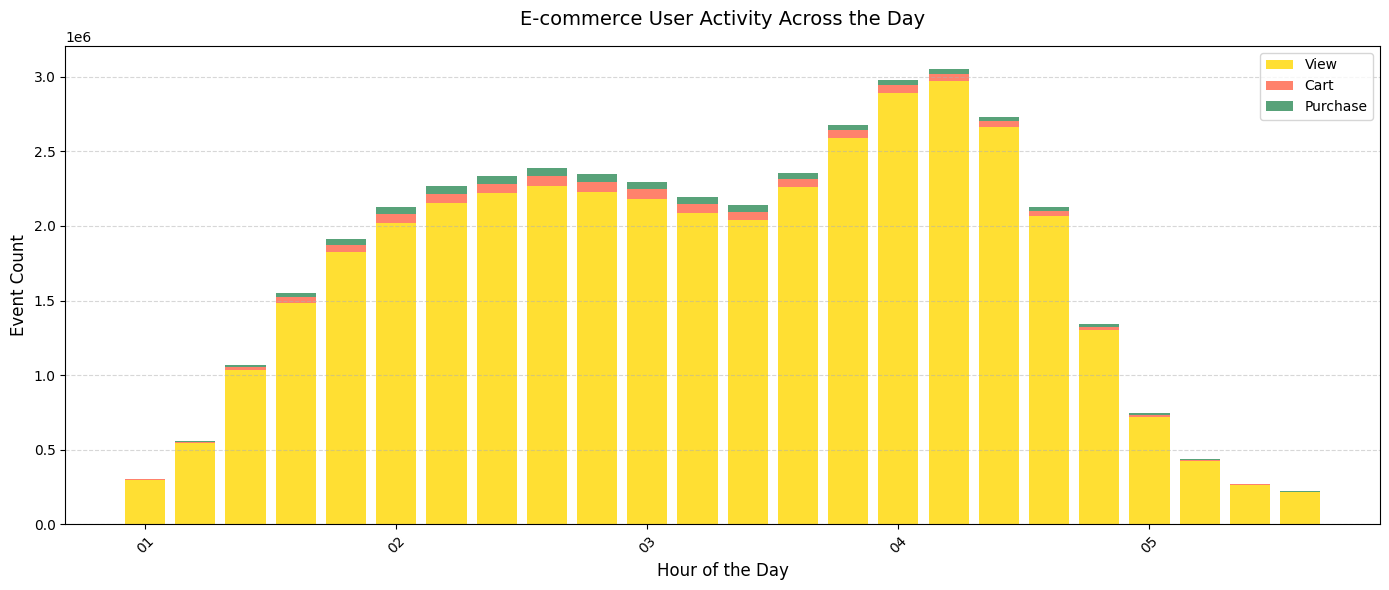

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Prepare the data
x = np.arange(len(hours)) # Numeric positions for the hours

# Set up figure
fig, ax = plt.subplots(figsize=(14, 6)) # Compact and neat figure

# Plotting the activities as stacked bars
ax.bar(x, view_counts, label='View', color='gold', alpha=0.8)
ax.bar(x, cart_counts, bottom=view_counts, label='Cart', color='tomato', alpha=0.8)
ax.bar(x, purchase_counts, bottom=[v + c for v, c in zip(view_counts, cart_counts)],
       label='Purchase', color='seagreen', alpha=0.8)

# Labels and Title
ax.set_xlabel('Hour of the Day', fontsize=12)
ax.set_ylabel('Event Count', fontsize=12)
ax.set_title('E-commerce User Activity Across the Day', fontsize=14, pad=15)

# Set x-axis ticks (silent handling)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    try:
        ax.set_xticklabels([f'{int(h):02d}' for h in hours], rotation=45)
    except:
        ax.set_xticklabels([str(h).zfill(2) for h in hours], rotation=45)

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Add legend
ax.legend(loc='upper right')

# Tighten layout
plt.tight_layout()

# Show the plot
plt.show()

Analysis: We can see from the graph that X number of users have already accessed our Ecommerce at 3:00 In the morning, it is increasing significantly in the afternoon and reached peak time at 16:00. Hence, a flash sale from 13:00 until 16:00 will help in increasing the impulsivity of the user for buying items